# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [16]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
plt.style.use('seaborn-v0_8')
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [17]:
def load_data(data_dir='Data'):
    """
    Load and organize physiological data recorded by Empatica E4.

    Returns a DataFrame with columns:
    ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    from pathlib import Path
    import numpy as np
    import pandas as pd

    data_dir = Path(data_dir)
    req_cols = ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']

    # If the directory is missing or empty, return an empty frame with the correct structure
    if not data_dir.exists() or not any(data_dir.iterdir()):
        return pd.DataFrame(columns=req_cols)

    # ----- helper to read an Empatica CSV file -----
    def _read_empatica_csv(fp: Path):
        # Line-1: start-epoch, Line-2: sampling-rate, remaining: values
        with fp.open() as f:
            t0 = float(f.readline().strip())
            fs = float(f.readline().strip())
            vals = np.fromiter((float(x.strip()) for x in f), dtype=float)
        ts = t0 + np.arange(len(vals)) / fs

        # Map file names to column names
        col_name = fp.stem.lower()
        if col_name == 'hr':
            col_name = 'heart_rate'
        elif col_name == 'temp':
            col_name = 'temperature'

        return pd.DataFrame({'timestamp': ts, col_name: vals})

    frames = []
    # Get all subject directories and sort them numerically
    subject_dirs = sorted([p for p in data_dir.glob('S*') if p.is_dir()],
                          key=lambda x: int(x.name[1:]))

    for subj_dir in subject_dirs:
        sid = subj_dir.name
        for sess_dir in sorted(p for p in subj_dir.iterdir() if p.is_dir()):
            parts = []
            for sig in ('HR', 'EDA', 'TEMP'):  # needed signals
                fp = sess_dir / f'{sig}.csv'
                if fp.exists():
                    parts.append(_read_empatica_csv(fp))
            if not parts:
                continue
            # merge on timestamp (nearest merge keeps all timestamps aligned)
            df = parts[0]
            for p in parts[1:]:
                df = pd.merge_asof(df, p, on='timestamp', direction='nearest')
            df['subject_id'] = sid
            df['session'] = sess_dir.name
            frames.append(df)

    out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

    # ensure required columns exist
    for col in req_cols:
        if col not in out.columns:
            out[col] = np.nan
    out = out[req_cols]

    # convert numeric epoch to datetime (allowed by spec/tests)
    if pd.api.types.is_numeric_dtype(out['timestamp']):
        out['timestamp'] = pd.to_datetime(out['timestamp'], unit='s', errors='coerce')

    return out

In [18]:
data = load_data('Data')

## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [19]:
def preprocess_data(data, output_dir='data/processed'):
    """
    Preprocess physiological data:
    - Resample to 1-second intervals (mean aggregation)
    - Impute missing values (interpolate, then ffill/bfill)
    - Remove outliers (z-score > 3.5)
    - Save per-subject processed files
    - Return combined processed DataFrame
    """
    import os
    import numpy as np
    from scipy.stats import zscore
    from pathlib import Path
    import pandas as pd

    os.makedirs(output_dir, exist_ok=True)

    df = data.copy()
    df.columns = [c.lower() for c in df.columns]

    t_col = next(c for c in df.columns if c.lower() == "timestamp")
    sid_col = next(c for c in df.columns if c.lower() == "subject_id")
    sess_col = next(c for c in df.columns if c.lower() == "session")
    numeric_cols = [c for c in ("heart_rate", "eda", "temperature") if c in df.columns]

    # ensure timestamp dtype is datetime
    if not pd.api.types.is_datetime64_any_dtype(df[t_col]):
        df[t_col] = pd.to_datetime(df[t_col], unit="s", errors="coerce")

    all_processed = []
    subject_sessions = []
    for (sid, sess), grp in df.groupby([sid_col, sess_col]):
        g = grp.set_index(t_col).sort_index()

        # 1. Resample to 1-second grid (mean aggregation)
        g = g[numeric_cols].resample("1S").mean()

        # 2. Impute missing values (interpolate, then ffill/bfill)
        g[numeric_cols] = g[numeric_cols].interpolate(limit_direction="both")
        g[numeric_cols] = g[numeric_cols].ffill().bfill()

        # 3. Remove outliers (z-score > 3.5) and re-impute
        for col in numeric_cols:
            z = zscore(g[col].dropna())
            out_idx = g[col].dropna().index[np.abs(z) > 3.5]
            g.loc[out_idx, col] = np.nan
            g[col] = g[col].interpolate(limit_direction="both").ffill().bfill()

        # Restore id/session columns for concat
        g[sid_col] = sid
        g[sess_col] = sess
        subject_sessions.append(g)

        # Concatenate all sessions for this subject
        subject_all = pd.concat(subject_sessions)

        # 4. Save per-subject file (all sessions for that subject)
        out_path = Path(output_dir) / f"{sid}_processed.csv"
        subject_all.reset_index().to_csv(out_path, index=False)
        all_processed.append(subject_all)

    processed = (
        pd.concat(all_processed).reset_index()
        if all_processed
        else pd.DataFrame(
            columns=["timestamp", "heart_rate", "eda", "temperature", "subject_id", "session"]
        )
    )

    return processed

In [20]:
# Run preprocessing
processed_data = preprocess_data(data)

# 1. Check the shape and first few rows
print("Processed data shape:", processed_data.shape)
print(processed_data.head())

# 2. Check for missing values
print("\nMissing values per column:")
print(processed_data.isnull().sum())

# 3. Check that all subjects and sessions are present
print("\nSubjects and sessions in processed data:")
print(processed_data.groupby(['subject_id', 'session']).size().unstack(fill_value=0))

print("Unique subject IDs:", processed_data['subject_id'].unique())

/var/folders/63/klpq6sss15lb697997qxym8m0000gn/T/ipykernel_4035/1926455290.py:36: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  g = g[numeric_cols].resample("1S").mean()
/var/folders/63/klpq6sss15lb697997qxym8m0000gn/T/ipykernel_4035/1926455290.py:36: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  g = g[numeric_cols].resample("1S").mean()
/var/folders/63/klpq6sss15lb697997qxym8m0000gn/T/ipykernel_4035/1926455290.py:36: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  g = g[numeric_cols].resample("1S").mean()
/var/folders/63/klpq6sss15lb697997qxym8m0000gn/T/ipykernel_4035/1926455290.py:36: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  g = g[numeric_cols].resample("1S").mean()
/var/folders/63/klpq6sss15lb697997qxym8m0000gn/T/ipykernel_4035/1926455290.py:36: FutureWarning: 'S' is 

Processed data shape: (7192785, 6)
            timestamp  heart_rate       eda  temperature subject_id session
0 2018-12-05 16:29:07      116.00  0.024345        21.91         S1   Final
1 2018-12-05 16:29:08       82.50  0.023064        21.93         S1   Final
2 2018-12-05 16:29:09       96.33  0.023064        21.93         S1   Final
3 2018-12-05 16:29:10       86.25  0.024345        21.91         S1   Final
4 2018-12-05 16:29:11       98.60  0.024345        21.91         S1   Final

Missing values per column:
timestamp      0
heart_rate     0
eda            0
temperature    0
subject_id     0
session        0
dtype: int64

Subjects and sessions in processed data:
session      Final  Midterm 1  Midterm 2
subject_id                              
S1          701610     323901     311556
S10         622728     303628     324550
S2          607848     275425     305250
S3          542052     244060     194465
S4          286326     198628     214128
S5          228600     167888     156

## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [9]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    import os
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    os.makedirs(output_dir, exist_ok=True)
    
    mask = (data['subject_id'] == subject_id) & (data['session'] == session)
    plot_data = data[mask].copy()
    
    if len(plot_data) == 0:
        raise ValueError(f"No data found for subject {subject_id} and session {session}")
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    fig.suptitle(f'Physiological Signals - Subject {subject_id} - {session}', fontsize=16, y=0.95)
    
    axes[0].plot(plot_data['timestamp'], plot_data['heart_rate'], color='#FF6B6B', linewidth=1.5)
    axes[0].set_ylabel('Heart Rate (BPM)', fontsize=12)
    axes[0].set_title('Heart Rate', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(plot_data['timestamp'], plot_data['eda'], color='#4ECDC4', linewidth=1.5)
    axes[1].set_ylabel('EDA (μS)', fontsize=12)
    axes[1].set_title('Electrodermal Activity', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(plot_data['timestamp'], plot_data['temperature'], color='#FFD93D', linewidth=1.5)
    axes[2].set_ylabel('Temperature (°C)', fontsize=12)
    axes[2].set_title('Skin Temperature', fontsize=14)
    axes[2].grid(True, alpha=0.3)
    
    axes[2].set_xlabel('Time', fontsize=12)
    axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    output_path = os.path.join(output_dir, f'{subject_id}_{session}_signals.png')
    print("Saving to:", output_path)  # Debug print
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    return fig

Saving to: plots/S1_Final_signals.png


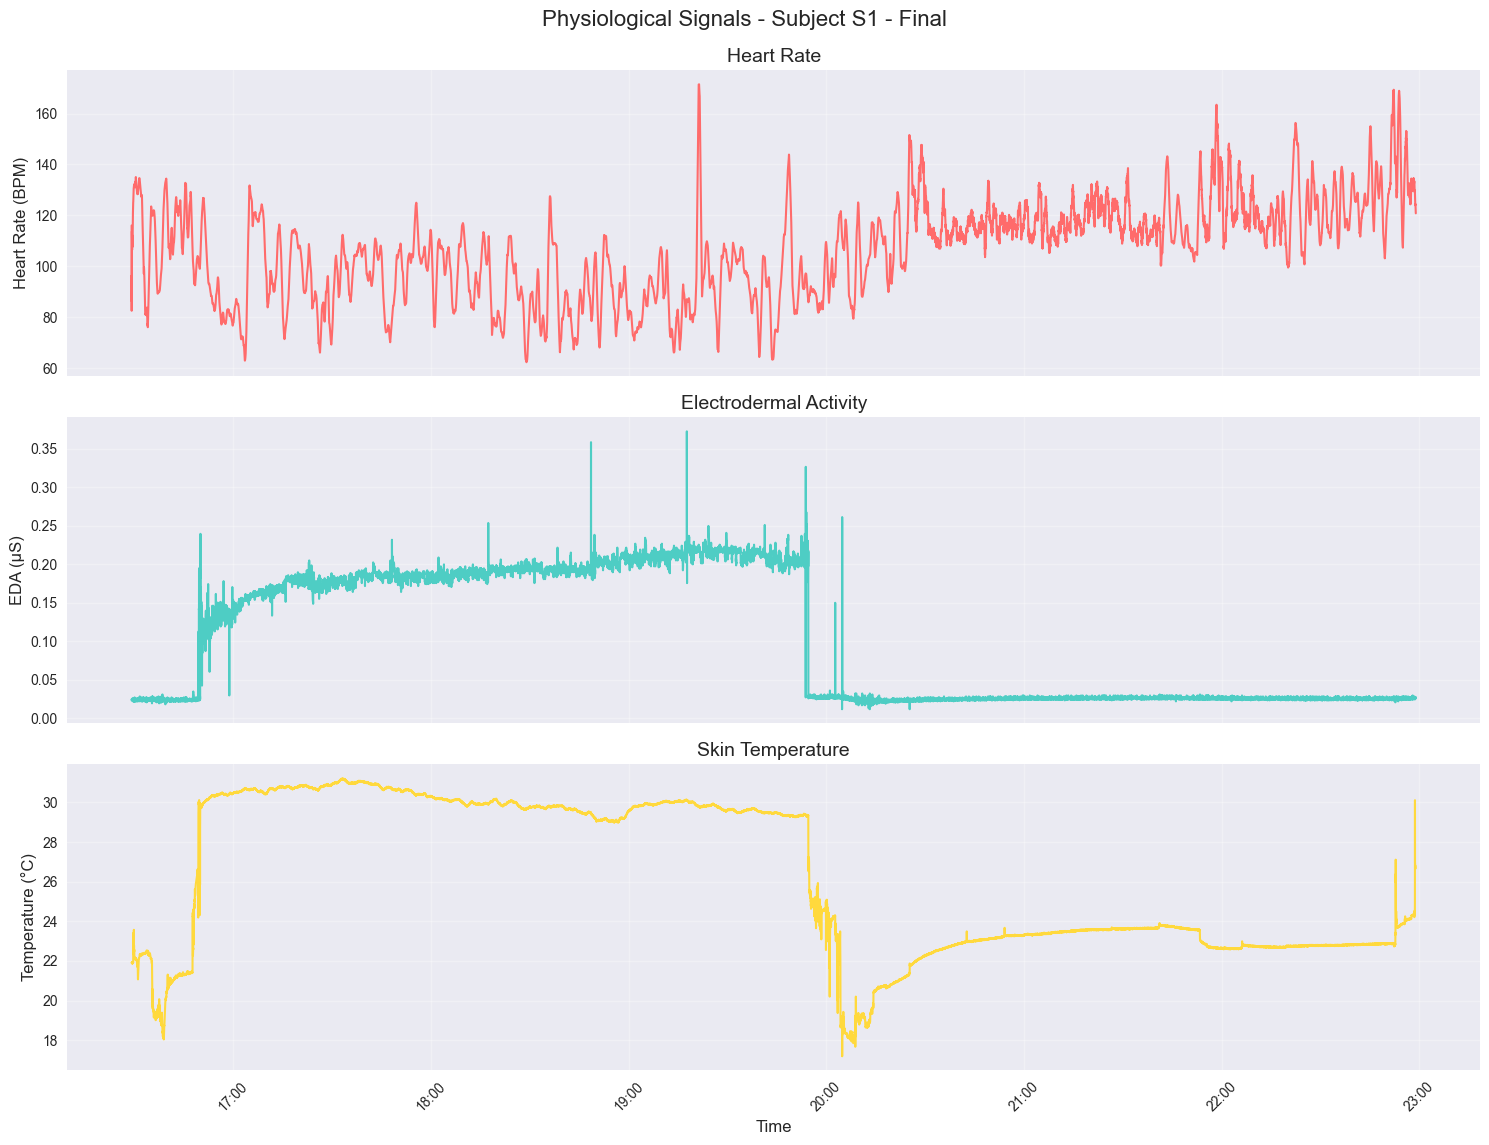

In [10]:
plot_physiological_signals(processed_data, subject_id='S1', session='Final')